# Transfer learning and fine-tuning parctice

[Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning)

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. **Feature Extraction**: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

2. **Fine-Tuning**: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
2. Build an input pipeline, in this case using Keras ImageDataGenerator
3. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
4. Train the model
5. Evaluate model


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2025-01-10 06:29:06.438174: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-10 06:29:12.557344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-10 06:29:14.715000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-10 06:29:15.215205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 06:29:18.674330: I tensorflow/core/platform/cpu_feature_guar

## Data preprocessing

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

### Data download

In [2]:
# Using local data downloaded from https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
PATH = 'data/image_data/cats_and_dogs_filtered/'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

print('Train directory:', train_dir)
print('Validation directory:', validation_dir)

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

Train directory: data/image_data/cats_and_dogs_filtered/train
Validation directory: data/image_data/cats_and_dogs_filtered/validation
Found 2000 files belonging to 2 classes.


I0000 00:00:1736461828.574437    2149 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736461833.380562    2149 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736461833.380614    2149 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736461833.393907    2149 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736461833.393945    2149 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

2025-01-10 06:30:39.082558: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


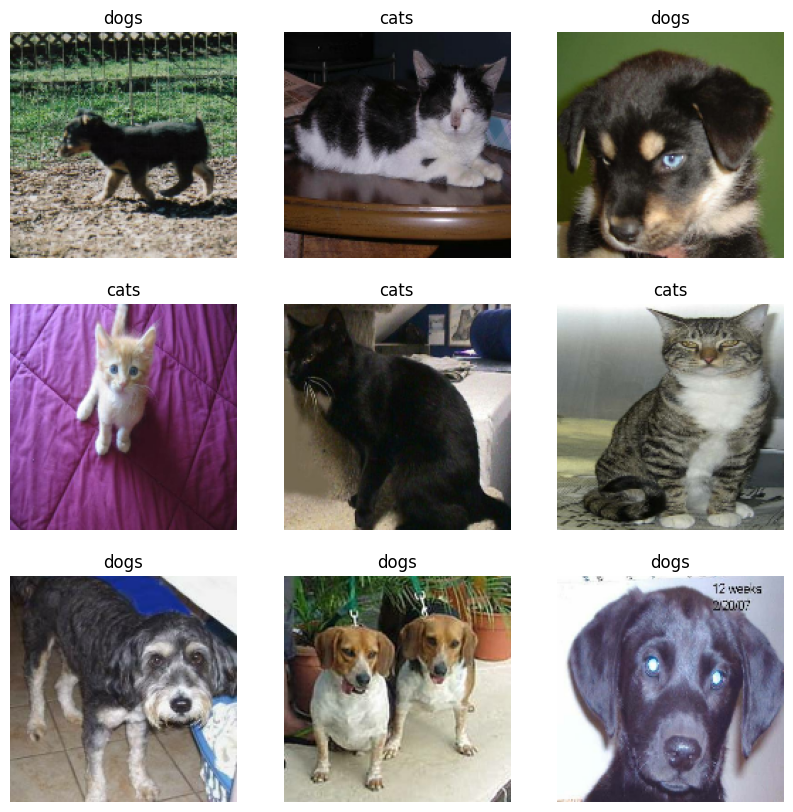

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

2025-01-10 06:30:41.187063: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


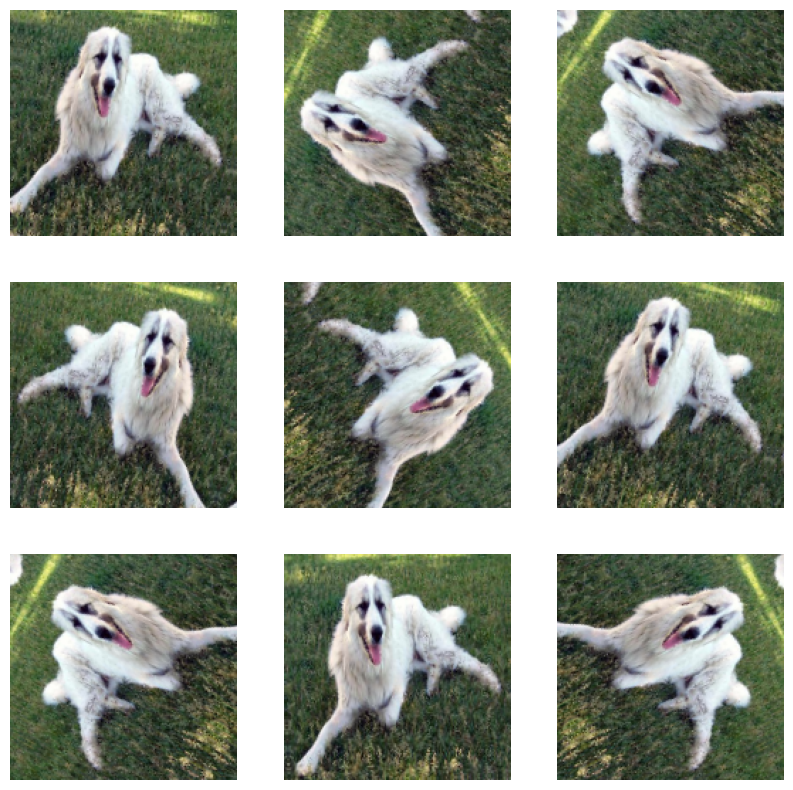

In [9]:
# Let's repeatedly apply these layers to the same image and see the result.

for image, _ in train_dataset.take(1):
      plt.figure(figsize=(10, 10))
      first_image = image[0]
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
          plt.imshow(augmented_image[0] / 255)
          plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)